In [1]:
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from wave_manifold.layers import Retina
from wave_manifold.layers import FunctionalLGN
from wave_manifold import preprocessing
from wave_manifold import manifold_analysis

In [13]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family':'arial'})

# Load the model retina

In [3]:
retina_file = open('../data/pretraining_retina.pkl', 'rb')
retina = pickle.load(retina_file)
retina_file.close()

# Initialize LGNs with random connections

In [4]:
#set number of lgns for analysis
num_lgns = 3

In [5]:
random_lgns = [FunctionalLGN(n_hidden=100) for _ in range(num_lgns)]

# Load pretrained weights/thresholds for pretrained LGNs

In [6]:
#get pretrained (pt) weights on simulated (sim) waves
pt_sim_weights = torch.load('../results/pretrained_weights.pt')
pt_sim_thresholds = torch.load('../results/pretrained_thresholds.pt')

#get pt weights on real waves
pt_REAL_weights = torch.load('../results/pretrained_REAL_weights.pt')
pt_REAL_thresholds = torch.load('../results/pretrained_REAL_thresholds.pt')

#get pt weights on real waves, but shuffled (no time correlation)
pt_REAL_SHUF_weights = torch.load('../results/pretrained_REAL_SHUFFLED_weights.pt')
pt_REAL_SHUF_thresholds = torch.load('../results/pretrained_REAL_SHUFFLED_thresholds.pt')

# Initialize LGNs with pretrained connections

In [7]:
pretrained_sim_lgns = [FunctionalLGN(n_hidden=100) for _ in range(num_lgns)]
pretrained_REAL_lgns = [FunctionalLGN(n_hidden=100) for _ in range(num_lgns)]
pretrained_REAL_SHUFFLED_lgns = [FunctionalLGN(n_hidden=100) for _ in range(num_lgns)]

for pt_sim_lgn, pt_REAL_lgn, pt_REAL_SHUF_lgn, rand_lgn, in zip(pretrained_sim_lgns, 
                                                                pretrained_REAL_lgns, 
                                                                pretrained_REAL_SHUFFLED_lgns, 
                                                                random_lgns):
    #set pretrained weights and thresholds
    #set hidden weights to same random weights as the random networks
    pt_sim_lgn.weights = pt_sim_weights
    pt_sim_lgn.thresholds = pt_sim_thresholds
    pt_sim_lgn.hidden_weights = rand_lgn.hidden_weights

    pt_REAL_lgn.weights = pt_REAL_weights
    pt_REAL_lgn.thresholds = pt_REAL_thresholds
    pt_REAL_lgn.hidden_weights = rand_lgn.hidden_weights
    
    pt_REAL_SHUF_lgn.weights = pt_REAL_SHUF_weights
    pt_REAL_SHUF_lgn.thresholds = pt_REAL_SHUF_thresholds
    pt_REAL_SHUF_lgn.hidden_weights = rand_lgn.hidden_weights


# Load training and test data

In [8]:
retinal_mnist_train = torch.load('../data/retinal_mnist_train.pt')
retinal_mnist_train_dict = torch.load('../data/retinal_mnist_train_dict.pt')
retinal_mnist_train_targets = torch.load('../data/retinal_mnist_train_targets.pt')

retinal_mnist_test = torch.load('../data/retinal_mnist_test.pt')
retinal_mnist_test_dict = torch.load('../data/retinal_mnist_test_dict.pt')
retinal_mnist_test_targets = torch.load('../data/retinal_mnist_test_targets.pt')

# Train classifiers

In [9]:
for rand_lgn, pt_sim_lgn, pt_REAL_lgn, pt_REAL_SHUF_lgn in zip(random_lgns,
                                                               pretrained_sim_lgns, 
                                                               pretrained_REAL_lgns, 
                                                               pretrained_REAL_SHUFFLED_lgns, 
                                                              ):    
                                                               
    rand_lgn.train_svm(retinal_mnist_train, retinal_mnist_train_targets)
    pt_sim_lgn.train_svm(retinal_mnist_train, retinal_mnist_train_targets)
    pt_REAL_lgn.train_svm(retinal_mnist_train, retinal_mnist_train_targets)
    pt_REAL_SHUF_lgn.train_svm(retinal_mnist_train, retinal_mnist_train_targets)

# Evaluate and plot classifier performance

In [11]:
random_train_accuracies = []
pretrained_sim_train_accuracies = []
pretrained_REAL_train_accuracies = []
pretrained_REAL_SHUFFLED_train_accuracies = []

for rand_lgn, pt_sim_lgn, pt_REAL_lgn, pt_REAL_SHUF_lgn in zip(random_lgns,
                                                               pretrained_sim_lgns, 
                                                               pretrained_REAL_lgns, 
                                                               pretrained_REAL_SHUFFLED_lgns, 
                                                              ): 
                                                              
    random_train_accuracies.append(rand_lgn.evaluate_svm_performance(retinal_mnist_train, retinal_mnist_train_targets))
    pretrained_sim_train_accuracies.append(pt_sim_lgn.evaluate_svm_performance(retinal_mnist_train, retinal_mnist_train_targets))
    pretrained_REAL_train_accuracies.append(pt_REAL_lgn.evaluate_svm_performance(retinal_mnist_train, retinal_mnist_train_targets))
    pretrained_REAL_SHUFFLED_train_accuracies.append(pt_REAL_SHUF_lgn.evaluate_svm_performance(retinal_mnist_train, retinal_mnist_train_targets))

random_test_accuracies = []
pretrained_sim_test_accuracies = []
pretrained_REAL_test_accuracies = []
pretrained_REAL_SHUFFLED_test_accuracies = []

for rand_lgn, pt_sim_lgn, pt_REAL_lgn, pt_REAL_SHUF_lgn in zip(random_lgns,
                                                               pretrained_sim_lgns, 
                                                               pretrained_REAL_lgns, 
                                                               pretrained_REAL_SHUFFLED_lgns, 
                                                              ): 
                                                              
    random_test_accuracies.append(rand_lgn.evaluate_svm_performance(retinal_mnist_test, retinal_mnist_test_targets))
    pretrained_sim_test_accuracies.append(pt_sim_lgn.evaluate_svm_performance(retinal_mnist_test, retinal_mnist_test_targets))
    pretrained_REAL_test_accuracies.append(pt_REAL_lgn.evaluate_svm_performance(retinal_mnist_test, retinal_mnist_test_targets))
    pretrained_REAL_SHUFFLED_test_accuracies.append(pt_REAL_SHUF_lgn.evaluate_svm_performance(retinal_mnist_test, retinal_mnist_test_targets))

mean_train_accs = [np.mean(pretrained_sim_train_accuracies),
                   np.mean(pretrained_REAL_train_accuracies),
                   np.mean(pretrained_REAL_SHUFFLED_train_accuracies),
                   np.mean(random_train_accuracies)
                  ]

std_train_accs = [np.std(pretrained_sim_train_accuracies),
                  np.std(pretrained_REAL_train_accuracies),
                  np.std(pretrained_REAL_SHUFFLED_train_accuracies),
                  np.std(random_train_accuracies)
                 ]

mean_test_accs = [np.mean(pretrained_sim_test_accuracies),
                  np.mean(pretrained_REAL_test_accuracies),
                  np.mean(pretrained_REAL_SHUFFLED_test_accuracies),
                  np.mean(random_test_accuracies)
                 ]

std_test_accs = [np.std(pretrained_sim_test_accuracies),
                 np.std(pretrained_REAL_test_accuracies),
                 np.std(pretrained_REAL_SHUFFLED_test_accuracies),
                 np.std(random_test_accuracies)
                ]

(0.0, 1.0)

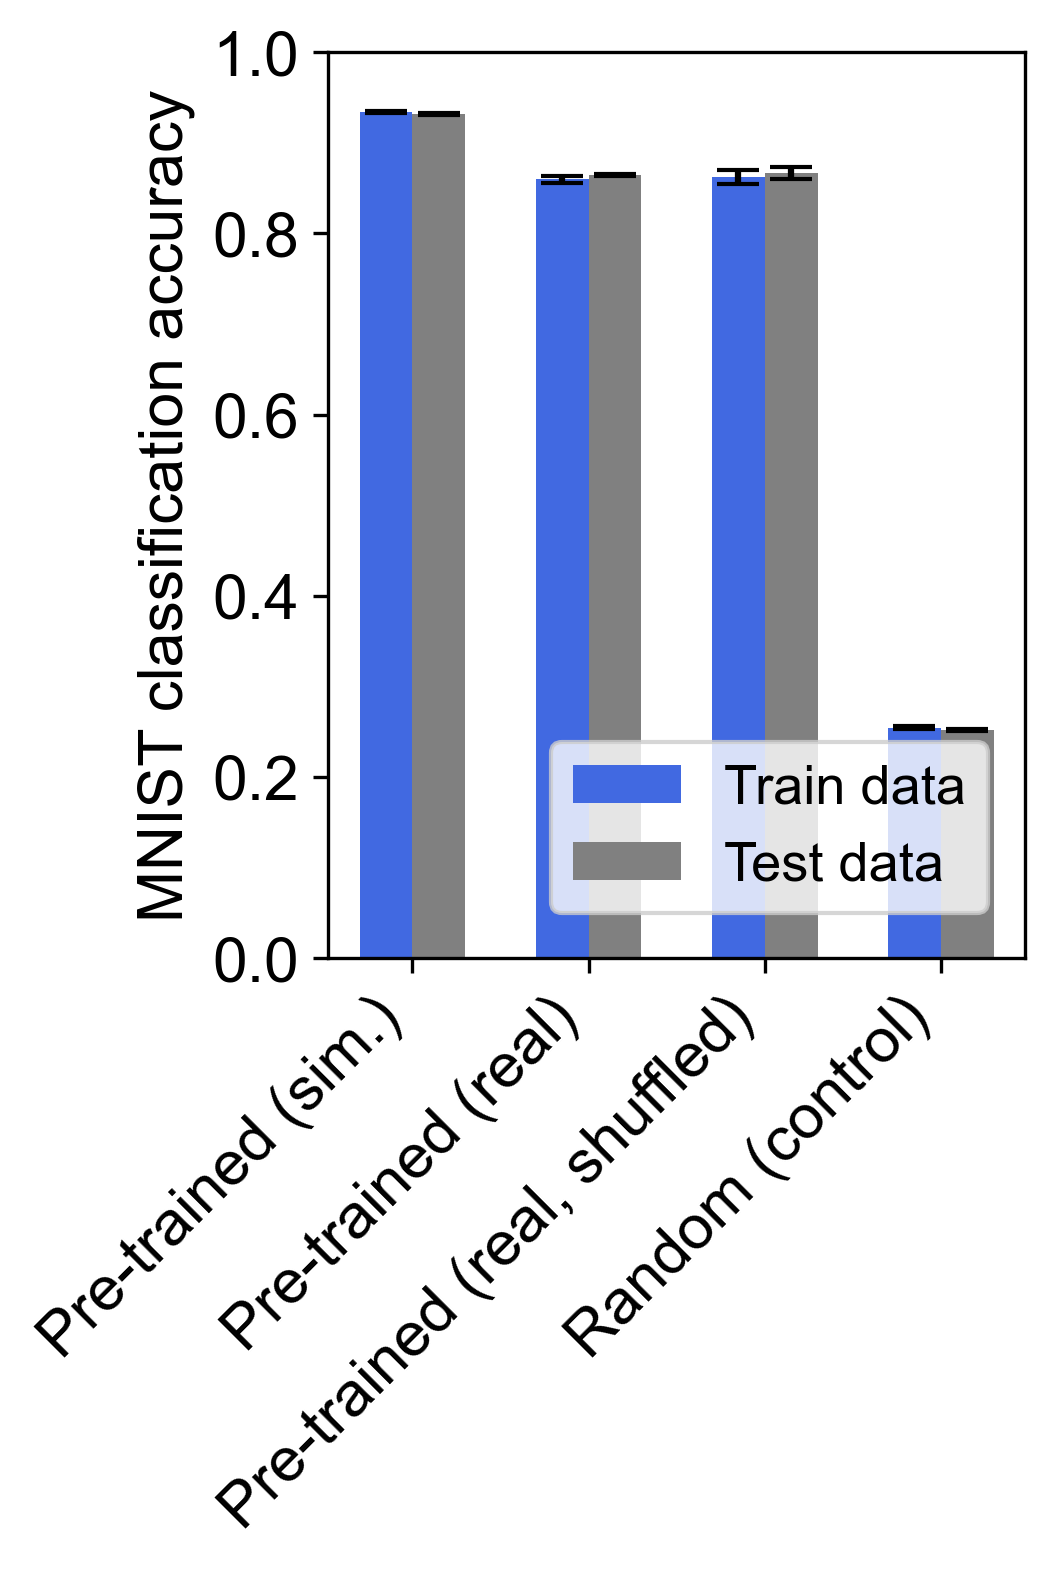

In [14]:
ind = np.arange(4)  # the x locations for the groups
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(3,4))
rects1 = ax.bar(ind - width/2, mean_train_accs, width, yerr=std_train_accs,
                label='Train data', color='royalblue', capsize=5)

rects2 = ax.bar(ind + width/2, mean_test_accs, width, yerr=std_test_accs,
                label='Test data', color='gray', capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MNIST classification accuracy', fontsize=15)
# ax.set_title('')
plt.yticks(fontsize=15)
ax.set_xticks(ind)
plt.xticks(rotation=45, ha="right")
ax.set_xticklabels(('Pre-trained (sim.)', 'Pre-trained (real)', 'Pre-trained (real, shuffled)', 'Random (control)'), fontsize=15)
ax.legend(fontsize=13, loc=(.32,.05))
ax.set_ylim(0,1)

# Look at manifold geometry of network representations

In [18]:
data_geometries = []
random_geometries = []
pretrained_sim_geometries = []
pretrained_REAL_geometries = []
pretrained_REAL_SHUFFLED_geometries = []

extent = lambda geometries : geometries[:,1,:] * np.sqrt(geometries[:,2,:])

for rand_lgn, pt_sim_lgn, pt_REAL_lgn, pt_REAL_SHUF_lgn in zip(random_lgns,
                                                               pretrained_sim_lgns, 
                                                               pretrained_REAL_lgns, 
                                                               pretrained_REAL_SHUFFLED_lgns 
                                                              ): 
    
    data_reps = manifold_analysis.get_reps_by_class(retinal_mnist_test_dict, rep_transform=None)
    rand_reps = manifold_analysis.get_reps_by_class(retinal_mnist_test_dict, rep_transform=rand_lgn.hidden_forward_pass, pool=False)
    pt_sim_reps = manifold_analysis.get_reps_by_class(retinal_mnist_test_dict, rep_transform=pt_sim_lgn.hidden_forward_pass, pool=False)
    pt_REAL_reps = manifold_analysis.get_reps_by_class(retinal_mnist_test_dict, rep_transform=pt_REAL_lgn.hidden_forward_pass, pool=False)
    pt_REAL_SHUF_reps = manifold_analysis.get_reps_by_class(retinal_mnist_test_dict, rep_transform=pt_REAL_SHUF_lgn.hidden_forward_pass, pool=False)

    data_geometries.append(manifold_analysis.manifold_analysis(data_reps, .001, 200))
    random_geometries.append(manifold_analysis.manifold_analysis(rand_reps, .001, 200))
    pretrained_sim_geometries.append(manifold_analysis.manifold_analysis(pt_sim_reps, .001, 200))
    pretrained_REAL_geometries.append(manifold_analysis.manifold_analysis(pt_REAL_reps, .001, 200))
    pretrained_REAL_SHUFFLED_geometries.append(manifold_analysis.manifold_analysis(pt_REAL_SHUF_reps, .001, 200))
    
data_geometries = np.column_stack((np.array(data_geometries), extent(data_geometries)[:,np.newaxis,:]))
random_geometries = np.column_stack((np.array(random_geometries), extent(random_geometries)[:,np.newaxis,:]))
pretrained_sim_geometries = np.column_stack((np.array(pretrained_sim_geometries), extent(pretrained_sim_geometries)[:,np.newaxis,:]))
pretrained_REAL_geometries = np.column_stack((np.array(pretrained_REAL_geometries), extent(pretrained_REAL_geometries)[:,np.newaxis,:]))
pretrained_REAL_SHUFFLED_geometries = np.column_stack((np.array(pretrained_REAL_SHUFFLED_geometries), extent(pretrained_REAL_SHUFFLED_geometries)[:,np.newaxis,:]))

mean_data_geometries = np.mean(data_geometries, axis=0)
mean_random_geometries = np.mean(random_geometries, axis=0)
mean_pretrained_sim_geometries = np.mean(pretrained_sim_geometries, axis=0)
mean_pretrained_REAL_geometries = np.mean(pretrained_REAL_geometries, axis=0)
mean_pretrained_REAL_SHUFFLED_geometries = np.mean(pretrained_REAL_SHUFFLED_geometries, axis=0)

std_data_geometries = np.std(data_geometries, axis=0)
std_random_geometries = np.std(random_geometries, axis=0)
std_pretrained_sim_geometries = np.std(pretrained_sim_geometries, axis=0)
std_pretrained_REAL_geometries = np.std(pretrained_REAL_geometries, axis=0)
std_pretrained_REAL_SHUFFLED_geometries = np.std(pretrained_REAL_SHUFFLED_geometries, axis=0)

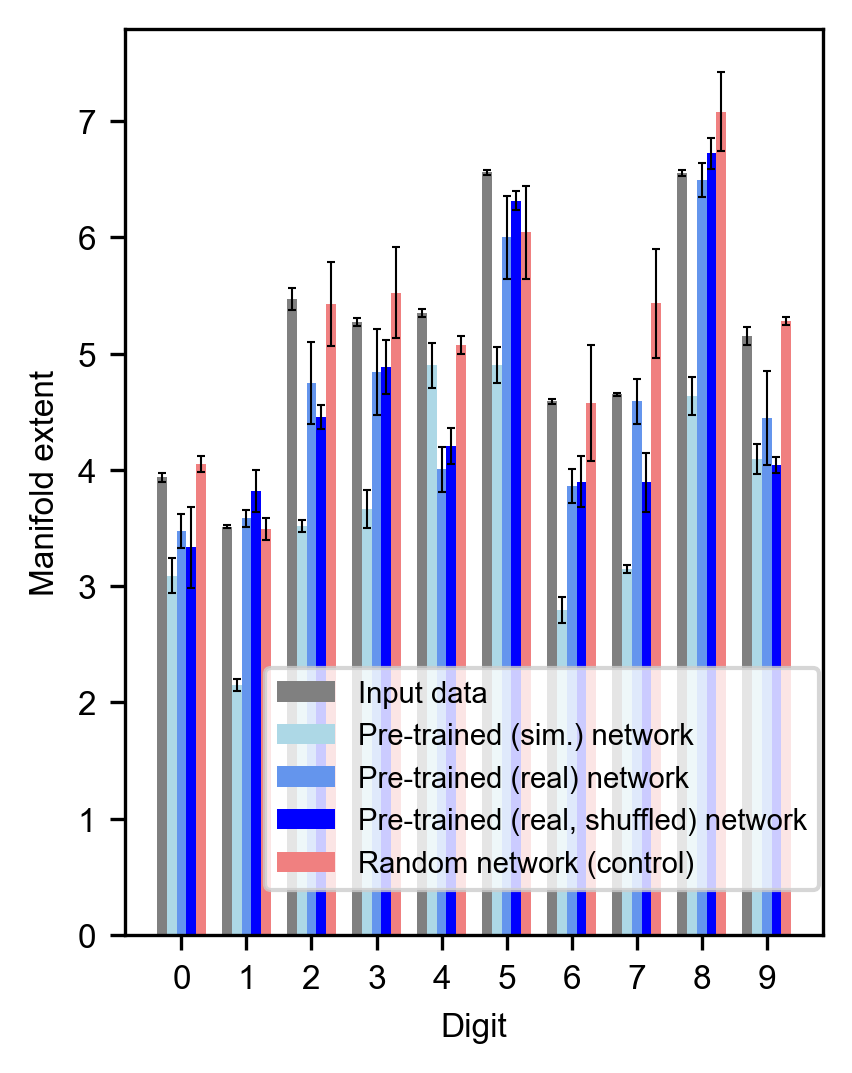

In [66]:
metric = 'extent'

ind = np.arange(10)  # the x locations for the groups
width = 0.15
capsize=1
lw=.5
capsize=1
capthick=.5
fontsize=8

if metric == 'capacity':
    idx = 0
    ylab = 'Manifold capacity'

if metric == 'radius':
    idx = 1
    ylab = 'Manifold radius'

if metric == 'dimension':
    idx = 2
    ylab = 'Manifold dimension'

if metric == 'extent':
    idx = 3
    ylab = 'Manifold extent'


fig, ax = plt.subplots(figsize=(3,4))

grp_rects = ax.bar(ind - 2*width, mean_data_geometries[idx,:], width, yerr=std_data_geometries[idx,:],
                label='Input data', color='gray', error_kw=dict(lw=lw, capsize=capsize, capthick=capthick))
pretrained_sim_rects = ax.bar(ind - width, mean_pretrained_sim_geometries[idx,:], width, yerr=std_pretrained_sim_geometries[idx,:],
                label='Pre-trained (sim.) network', color='lightblue', error_kw=dict(lw=lw, capsize=capsize, capthick=capthick))
pretrained_REAL_rects = ax.bar(ind, mean_pretrained_REAL_geometries[idx,:], width, yerr=std_pretrained_REAL_geometries[idx,:],
                label='Pre-trained (real) network', color='cornflowerblue', error_kw=dict(lw=lw, capsize=capsize, capthick=capthick))
pretrained_REAL_SHUFFLED_rects = ax.bar(ind + width, mean_pretrained_REAL_SHUFFLED_geometries[idx,:], width, yerr=std_pretrained_REAL_SHUFFLED_geometries[idx,:],
                label='Pre-trained (real, shuffled) network', color='b', error_kw=dict(lw=lw, capsize=capsize, capthick=capthick))       
random_rects = ax.bar(ind + 2*width, mean_random_geometries[idx,:], width, yerr=std_random_geometries[idx,:],
                label='Random network (control)', color='lightcoral', error_kw=dict(lw=lw, capsize=capsize, capthick=capthick))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(ylab, fontsize=fontsize)
ax.set_xlabel('Digit', fontsize=fontsize)
# ax.set_title('')
plt.yticks(fontsize=fontsize)
ax.set_xticks(ind)
plt.xticks(fontsize=fontsize)
# ax.set_xticklabels(('Random', 'Pre-trained (sim.)', 'Pre-trained (real)', 'Pre-trained (real, shuffled)'), fontsize=15)
ax.legend(fontsize=7, loc=(.2,.05))
# ax.set_ylim(0,80)

In [ ]:
ind = np.arange(10)  # the x locations for the groups
width = 0.15
capsize=1
lw=.5
capsize=1
capthick=.5
fontsize=8


fig, ax = plt.subplots(figsize=(3,4))

grp_rects = ax.bar(ind - 2*width, extent(mean_data_geometrie, width, yerr=std_data_geometries[idx,:],
                label='Input data', color='gray', error_kw=dict(lw=lw, capsize=capsize, capthick=capthick))
pretrained_sim_rects = ax.bar(ind - width, mean_pretrained_sim_geometries[idx,:], width, yerr=std_pretrained_sim_geometries[idx,:],
                label='Pre-trained (sim.) network', color='lightblue', error_kw=dict(lw=lw, capsize=capsize, capthick=capthick))
pretrained_REAL_rects = ax.bar(ind, mean_pretrained_REAL_geometries[idx,:], width, yerr=std_pretrained_REAL_geometries[idx,:],
                label='Pre-trained (real) network', color='cornflowerblue', error_kw=dict(lw=lw, capsize=capsize, capthick=capthick))
pretrained_REAL_SHUFFLED_rects = ax.bar(ind + width, mean_pretrained_REAL_SHUFFLED_geometries[idx,:], width, yerr=std_pretrained_REAL_SHUFFLED_geometries[idx,:],
                label='Pre-trained (real, shuffled) network', color='b', error_kw=dict(lw=lw, capsize=capsize, capthick=capthick))       
random_rects = ax.bar(ind + 2*width, mean_random_geometries[idx,:], width, yerr=std_random_geometries[idx,:],
                label='Random network (control)', color='lightcoral', error_kw=dict(lw=lw, capsize=capsize, capthick=capthick))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(ylab, fontsize=fontsize)
ax.set_xlabel('Digit', fontsize=fontsize)
# ax.set_title('')
plt.yticks(fontsize=fontsize)
ax.set_xticks(ind)
plt.xticks(fontsize=fontsize)
# ax.set_xticklabels(('Random', 'Pre-trained (sim.)', 'Pre-trained (real)', 'Pre-trained (real, shuffled)'), fontsize=15)
ax.legend(fontsize=7)
# ax.set_ylim(0,80)

# Look at participation ratio of network representations

In [22]:
GRP_participation_ratios = []
random_participation_ratios = []
pretrained_sim_participation_ratios = []
pretrained_REAL_participation_ratios = []
pretrained_REAL_SHUFFLED_participation_ratios = []

transposeGRP = lambda x : GaussianRandomProjection(random_lgns[0].n_hidden).fit_transform(x.T)

GRPs = [transposeGRP for _ in range(num_lgns)]

pca = PCA()
sc = StandardScaler()

for grp, rand_lgn, pt_sim_lgn, pt_REAL_lgn, pt_REAL_SHUF_lgn in zip(GRPs,
                                                                    random_lgns,
                                                                    pretrained_sim_lgns, 
                                                                    pretrained_REAL_lgns, 
                                                                    pretrained_REAL_SHUFFLED_lgns 
                                                                    ): 
    pca.fit(sc.fit_transform(grp(retinal_mnist_test)))
    GRP_participation_ratios.append(manifold_analysis.get_partic_ratio(pca.explained_variance_))

    pca.fit(sc.fit_transform(rand_lgn.hidden_forward_pass(retinal_mnist_test, pool=False).T))
    random_participation_ratios.append(manifold_analysis.get_partic_ratio(pca.explained_variance_))

    pca.fit(sc.fit_transform(pt_sim_lgn.hidden_forward_pass(retinal_mnist_test, pool=False).T))
    pretrained_sim_participation_ratios.append(manifold_analysis.get_partic_ratio(pca.explained_variance_))

    pca.fit(sc.fit_transform(pt_REAL_lgn.hidden_forward_pass(retinal_mnist_test, pool=False).T))
    pretrained_REAL_participation_ratios.append(manifold_analysis.get_partic_ratio(pca.explained_variance_))

    pca.fit(sc.fit_transform(pt_REAL_SHUF_lgn.hidden_forward_pass(retinal_mnist_test, pool=False).T))
    pretrained_REAL_SHUFFLED_participation_ratios.append(manifold_analysis.get_partic_ratio(pca.explained_variance_))

mean_prs = [np.mean(GRP_participation_ratios),
            np.mean(pretrained_sim_participation_ratios),
            np.mean(pretrained_REAL_participation_ratios),
            np.mean(pretrained_REAL_SHUFFLED_participation_ratios),
            np.mean(random_participation_ratios),]

std_prs = [np.std(GRP_participation_ratios),
            np.std(pretrained_sim_participation_ratios),
            np.std(pretrained_REAL_participation_ratios),
            np.std(pretrained_REAL_SHUFFLED_participation_ratios),
            np.std(random_participation_ratios),]

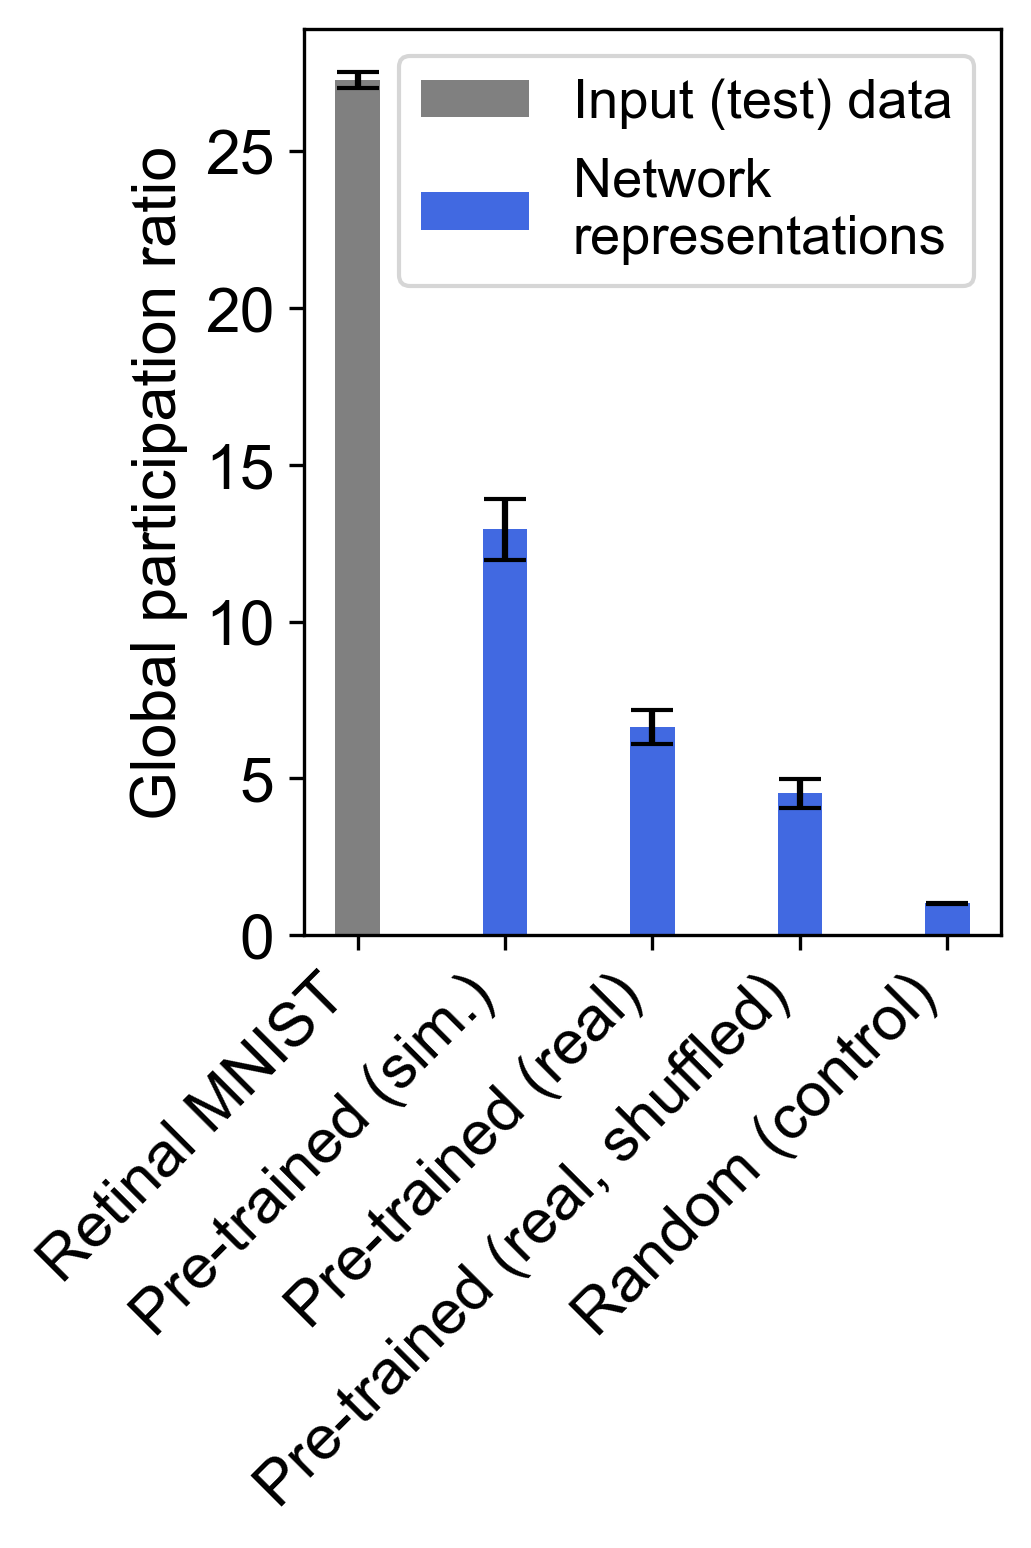

In [23]:
ind = np.arange(1,5)  # the x locations for the groups
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(3,4))
rects0 = ax.bar(0, mean_prs[0], width, yerr=std_prs[0],
                label='Input (test) data', color='gray', capsize=5)
rects1 = ax.bar(ind, mean_prs[1:], width, yerr=std_prs[1:],
                label='Network \nrepresentations', color='royalblue', capsize=5)
            
        

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Global participation ratio', fontsize=15)
# ax.set_title('')
plt.yticks(fontsize=15)
ax.set_xticks(np.arange(5))
plt.xticks(rotation=45, ha="right")
ax.set_xticklabels(('Retinal MNIST', 'Pre-trained (sim.)', 'Pre-trained (real)', 'Pre-trained (real, shuffled)', 'Random (control)'), fontsize=15)
ax.legend(fontsize=13)
# ax.set_ylim(0,1)